In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
gdf_edu = gpd.read_file('EduLevel.geojson')

In [3]:
gdf_income=gpd.read_file('Income.geojson')

In [4]:
gdf_uni=gpd.read_file('Colleges_and_Universities.zip')

In [5]:
grs= gpd.read_file('GroceryStores.geojson')

In [6]:
gdf_block = gpd.read_file('acs2019_5yr_B01003_15000US060374028011.geojson')

In [7]:
gdf_edu = gdf_edu.drop([0])

In [8]:
gdf_block.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6426 entries, 0 to 6425
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             6426 non-null   object  
 1   name              6426 non-null   object  
 2   B01003001         6426 non-null   float64 
 3   B01003001, Error  6426 non-null   float64 
 4   geometry          6426 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 251.1+ KB


In [9]:
gdf_block = gdf_block[['geoid','B01003001','geometry']]

# rename the columns
gdf_block.columns = ['FIPS','TotalPop','geometry']

In [10]:
gdf_block.head()

,FIPS,TotalPop,geometry
0,05000US06037,10081570.0,"MULTIPOLYGON (((-118.70339 34.16859, -118.7033..."
1,15000US060371011101,1688.0,"MULTIPOLYGON (((-118.29133 34.26008, -118.2913..."
2,15000US060371011102,1614.0,"MULTIPOLYGON (((-118.30229 34.25870, -118.3009..."
3,15000US060371011103,981.0,"MULTIPOLYGON (((-118.30080 34.26327, -118.2979..."
4,15000US060371011221,2156.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."


In [11]:
gdf_block.tail()

,FIPS,TotalPop,geometry
6421,15000US060379800311,1175.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
6422,15000US060379800331,16.0,"MULTIPOLYGON (((-118.24897 33.75590, -118.2470..."
6423,15000US060379901000,0.0,"MULTIPOLYGON (((-118.95114 33.99643, -118.9505..."
6424,15000US060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
6425,15000US060379903000,0.0,"MULTIPOLYGON (((-118.47656 33.75038, -118.4661..."


In [12]:
gdf_block=gdf_block.drop(2515)

In [13]:
gdf_block['FIPS'] = gdf_block['FIPS'].str.replace('15000US','')
gdf_block.tail()

,FIPS,TotalPop,geometry
6421,060379800311,1175.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
6422,060379800331,16.0,"MULTIPOLYGON (((-118.24897 33.75590, -118.2470..."
6423,060379901000,0.0,"MULTIPOLYGON (((-118.95114 33.99643, -118.9505..."
6424,060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
6425,060379903000,0.0,"MULTIPOLYGON (((-118.47656 33.75038, -118.4661..."


In [14]:
gdf_block = gdf_block[gdf_block['TotalPop']>100]

In [15]:
gdf_block = gdf_block.to_crs(epsg=3857)

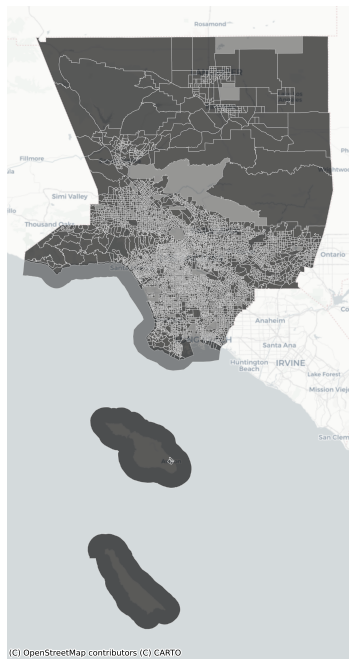

In [16]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

gdf_block.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [18]:
gdf_uni.shape

(217, 30)

In [34]:
list(gdf_uni)

['OBJECTID',
 'source',
 'ext_id',
 'cat1',
 'cat2',
 'cat3',
 'org_name',
 'Name',
 'addrln1',
 'addrln2',
 'city',
 'state',
 'hours',
 'phones',
 'url',
 'info1',
 'info2',
 'post_id',
 'descriptio',
 'zip',
 'link',
 'use_type',
 'latitude',
 'longitude',
 'date_updat',
 'email',
 'dis_status',
 'POINT_X',
 'POINT_Y',
 'geometry']

In [36]:
columns_to_keep = ['OBJECTID',
 'Name',
 'latitude',
 'longitude',
 'geometry']

In [37]:
gdf_uni= gdf_uni[columns_to_keep]

In [39]:
gdf_uni = gpd.GeoDataFrame(gdf_uni, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(gdf_uni.longitude, gdf_uni.latitude))

In [40]:
gdf_uni = gdf_uni.to_crs(epsg=3857)

In [43]:
gdf_uni.longitude = gdf_uni.longitude.astype('float')
gdf_uni.latitude = gdf_uni.latitude.astype('float')

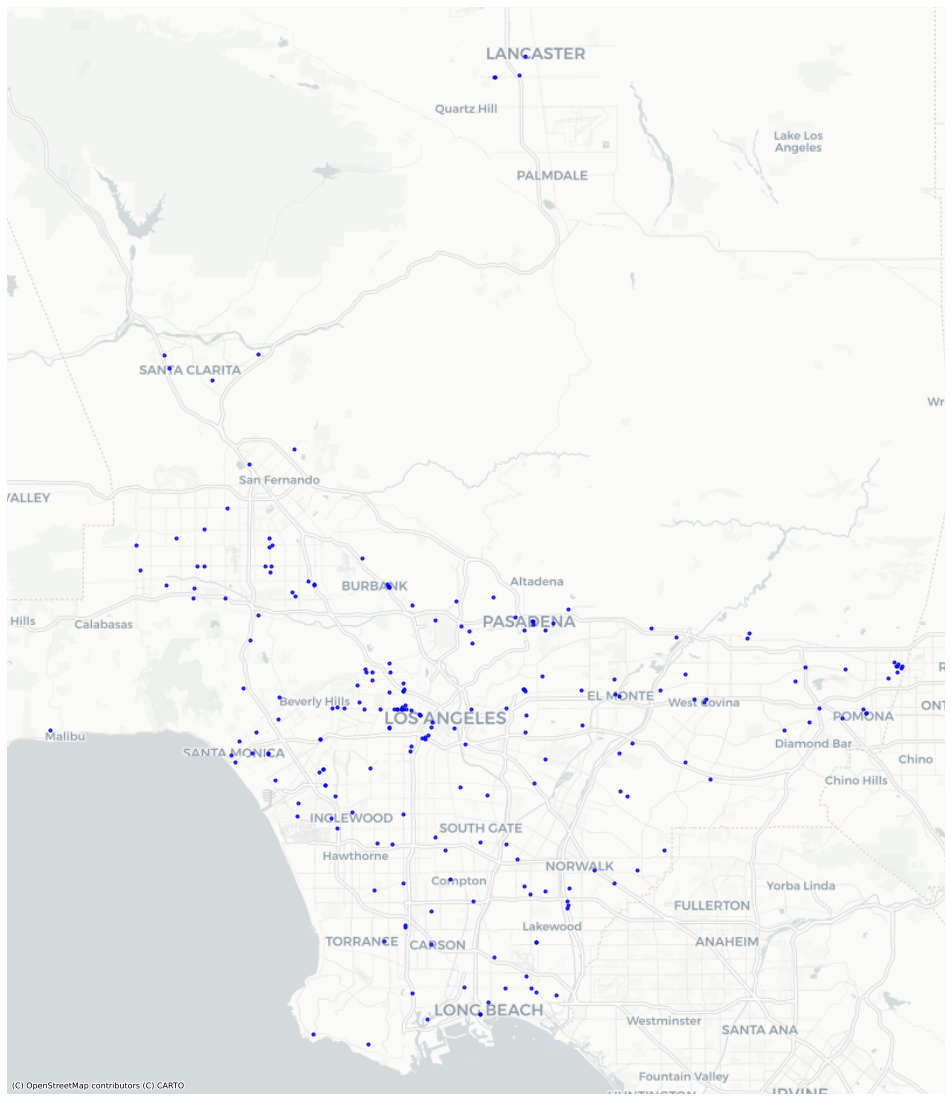

In [44]:
fig,ax = plt.subplots(figsize=(20,20))

gdf_uni.plot(ax=ax,
             color='blue',
             markersize=10, alpha=0.8)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [45]:
minx, miny, maxx, maxy = grs.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13229586.772141328
-13102994.247211216
3940847.1884405594
4139511.7755141906


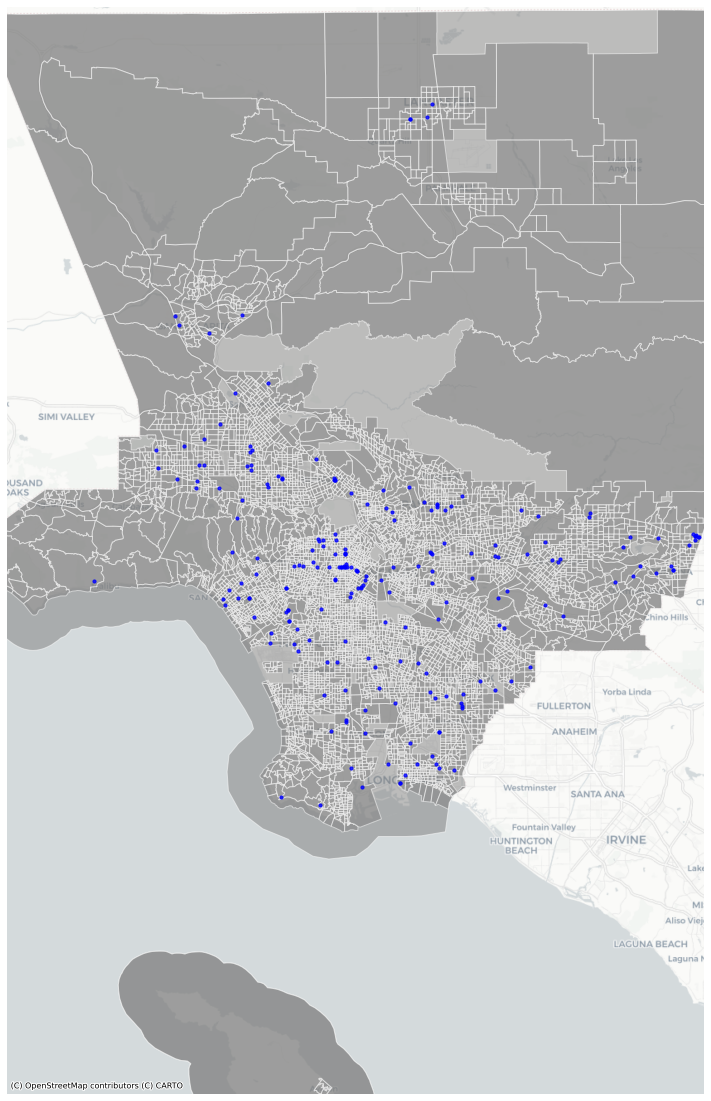

In [47]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_block.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

gdf_uni.plot(ax=ax,
            color='blue',
            markersize=10,
            alpha=0.8)

ax.set_xlim(minx - 1000, maxx + 1000) 
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [48]:
join = gpd.sjoin(gdf_uni, gdf_block, how='left')
join.head(20)

,OBJECTID,Name,latitude,longitude,geometry,index_right,FIPS,TotalPop
0,2878,California State Polytechnic University - Pomona,34.049531,-117.814466,POINT (-13115046.363 4035454.770),0,05000US06037,10081570.0
0,2878,California State Polytechnic University - Pomona,34.049531,-117.814466,POINT (-13115046.363 4035454.770),2863,060374024032,4239.0
1,2895,"California State University, The - Office Of T...",33.764616,-118.201257,POINT (-13158103.740 3997239.328),5258,060375760012,2823.0
1,2895,"California State University, The - Office Of T...",33.764616,-118.201257,POINT (-13158103.740 3997239.328),0,05000US06037,10081570.0
2,2973,California State University Los Angeles,34.062769,-118.170923,POINT (-13154726.975 4037233.486),0,05000US06037,10081570.0
2,2973,California State University Los Angeles,34.062769,-118.170923,POINT (-13154726.975 4037233.486),1223,060372017001,2299.0
3,3097,Los Angeles Community College District,34.049138,-118.258111,POINT (-13164432.699 4035401.969),0,05000US06037,10081570.0
3,3097,Los Angeles Community College District,34.049138,-118.258111,POINT (-13164432.699 4035401.969),1306,060372077101,4667.0
4,11961,Hebrew Union College-Jewish Institute Of Religion,34.025458,-118.282567,POINT (-13167155.128 4032220.926),0,05000US06037,10081570.0
4,11961,Hebrew Union College-Jewish Institute Of Religion,34.025458,-118.282567,POINT (-13167155.128 4032220.926),1676,060372247001,2450.0


In [49]:
join= join[join.FIPS!='05000US06037']
join.head()

,OBJECTID,Name,latitude,longitude,geometry,index_right,FIPS,TotalPop
0,2878,California State Polytechnic University - Pomona,34.049531,-117.814466,POINT (-13115046.363 4035454.770),2863,060374024032,4239.0
1,2895,"California State University, The - Office Of T...",33.764616,-118.201257,POINT (-13158103.740 3997239.328),5258,060375760012,2823.0
2,2973,California State University Los Angeles,34.062769,-118.170923,POINT (-13154726.975 4037233.486),1223,060372017001,2299.0
3,3097,Los Angeles Community College District,34.049138,-118.258111,POINT (-13164432.699 4035401.969),1306,060372077101,4667.0
4,11961,Hebrew Union College-Jewish Institute Of Religion,34.025458,-118.282567,POINT (-13167155.128 4032220.926),1676,060372247001,2450.0


In [50]:
edu_joined = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='school_count')
edu_joined.head()

,FIPS,school_count
0,060373107022,3
1,060374019011,3
2,060374808021,3
3,060374019012,3
4,060375545211,3


In [53]:
edu_merge =gdf_block.merge(edu_joined,on='FIPS')

In [54]:
edu_merge.head()

,FIPS,TotalPop,geometry,school_count
0,060371021041,2797.0,"MULTIPOLYGON (((-13174531.826 4057513.418, -13...",1
1,060371061111,1404.0,"MULTIPOLYGON (((-13182603.157 4071231.574, -13...",1
2,060371066041,498.0,"MULTIPOLYGON (((-13189067.479 4069621.091, -13...",1
3,060371114001,2745.0,"MULTIPOLYGON (((-13191626.269 4062578.493, -13...",1
4,060371132322,2045.0,"MULTIPOLYGON (((-13203751.077 4059631.647, -13...",1


/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


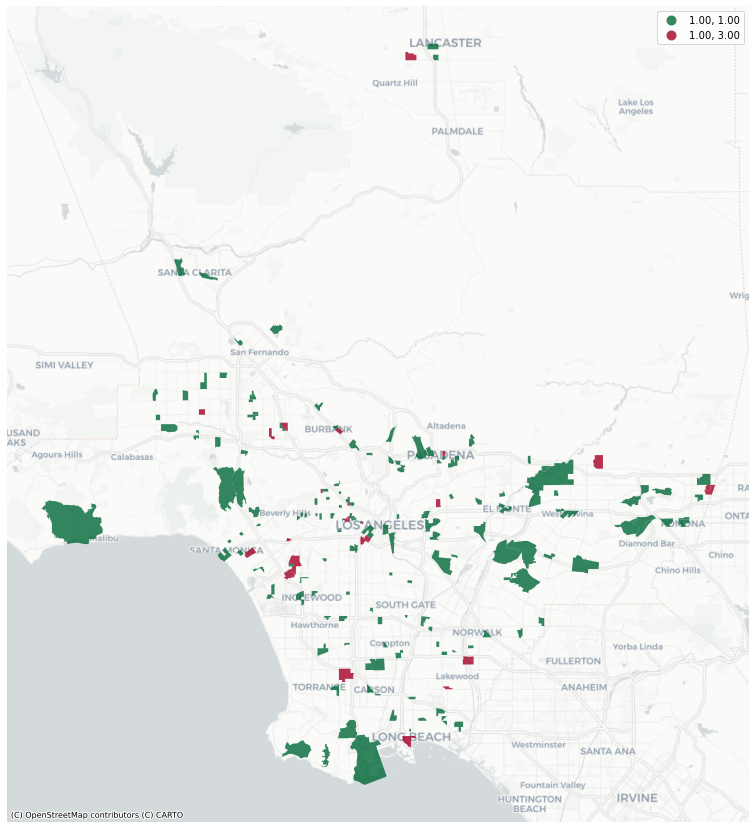

In [56]:
fig,ax = plt.subplots(figsize=(15,15))

edu_merge.plot(ax=ax,
        column='school_count',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)